In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()

In [2]:
# functions

K = 5

def truth(p, K = 5):
    # A
    Sigma = np.random.normal(scale = 1.0, size = (p, p))
    u, a, vt = np.linalg.svd(Sigma)
    Lambda = np.diag(np.sqrt(a[:K]))
    V = np.mat(u[:,:K]) * Lambda
    A = V * V.T
    return V, A

def Cholesky(V):
    p, K = V.shape
    V = np.mat(V)
    R = V[:K,:]
    q, r = np.linalg.qr(R.T)
    N = V * q
    for i in range(K):
        if N[i,i] < 0:
            N[:,i] = - N[:,i]

    return N
    
def logCholesky(V):
    N = Cholesky(V)
    p, K = V.shape
    for k in range(K):
        N[k,k] = np.log(N[k,k])
    return N



def noise(N, sigma):
    p, K = N.shape
    N_noise = np.zeros((p,K))
    for i in range(p):
        for j in range(K):
            if i>=j:
                N_noise[i,j] = N[i,j] + np.random.normal(scale = sigma)
    
    return N_noise

def inv_log(N):
    p, K = N.shape
    for k in range(K):
        N[k,k] = np.exp(N[k,k])
    
    return N


def Mean(M, sigma = 1):
    N = logCholesky(V)
    for m in range(M):
        for i in range(p):      
            for j in range(K):
                if i>=j:
                    N[i,j] = N[i,j] + np.random.normal(scale = sigma) / M
    
    N = np.mat(inv_log(N))
    A_mean = N * N.T
    error = np.linalg.norm(A_mean - A, ord = 'fro')
    return error

def MeanEuclid(M, sigma = 1):
    A_list = np.zeros((M,p,p))
    for m in range(M):
        N = logCholesky(V)
        for i in range(p):      
            for j in range(K):
                if i>=j:
                    N[i,j] = N[i,j] + np.random.normal(scale = sigma)
        N = np.mat(inv_log(N))
        A_list[m,:,:] = N * N.T
    
    A_avg = np.zeros((p, p))
    for m in range(M):
        A_avg = A_avg + A_list[m,:,:] / M

    u, a, vt = np.linalg.svd(A_avg)
    V_est = np.mat(u[:,:K])
    A_avg_lowrank = V_est * np.diag(a[:K]) * V_est.T

    error = np.linalg.norm(A_avg_lowrank - A, ord = 'fro')
    return error

    


In [9]:
# experiment one
p_list = [100, 200, 300, 400]
M_list = np.arange(30, 300, step = 30)

p_len = len(p_list)
M_len = len(M_list)
error = np.zeros((p_len, M_len))
error_euclid = np.zeros((p_len, M_len))
for i in range(p_len):
    p = p_list[i]
    V, A = truth(p)
    for j in range(M_len):
        M = M_list[j]
        error[i,j] = Mean(M)
        error_euclid[i,j] = MeanEuclid(M)

findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


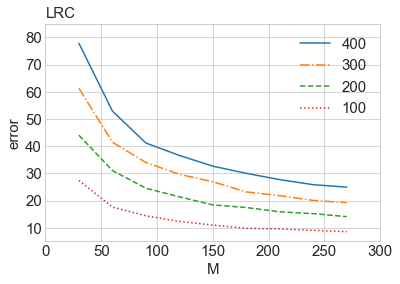

In [7]:
# plot
plt.style.use("seaborn-whitegrid")
lll = ['-', '-.', '--', ':']
for i in range(p_len):
    plt.plot(M_list, error[p_len - 1 - i,:], linestyle = lll[i], label = p_list[p_len - 1 - i])

plt.ylim((5,85))
plt.xlim((0,300))
plt.xlabel("M", size = 15)
plt.ylabel("error", size = 15)
plt.legend(loc = "upper right", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("LRC", loc = "left", size = 15)
#ax = plt.axes()
#ax.spines["top"].set_color("black")
#ax.spines["bottom"].set_color("black")
#ax.spines["left"].set_color("black")
#ax.spines["right"].set_color("black")
plt.rcParams['pdf.use14corefonts'] = True
plt.savefig("fig-1.pdf")


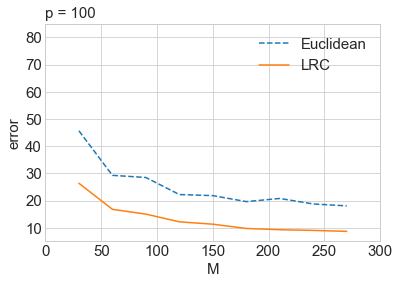

In [10]:
# plot
plt.style.use("seaborn-whitegrid")
i = 0
plt.plot(M_list, error_euclid[i,:], linestyle = lll[2], label = "Euclidean")
plt.plot(M_list, error[i,:], linestyle = lll[0], label = 'LRC')

plt.ylim((5,85))
plt.xlim((0,300))
plt.xlabel("M", fontsize = 15)
plt.ylabel("error", fontsize = 15)
plt.title("p = 100", loc = "left", fontsize = 15)
plt.legend(loc = "upper right", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#ax = plt.axes()
#ax.spines["top"].set_color("black")
#ax.spines["bottom"].set_color("black")
#ax.spines["left"].set_color("black")
#ax.spines["right"].set_color("black")
plt.rcParams['pdf.use14corefonts'] = True
plt.savefig("fig-2.pdf")

In [3]:
# experiment two
# functions

p = 100
K = 5

def data(V, M, sigma = 0.5, n = 2000):
    p, K = V.shape
    N_list = np.zeros((M, p, K))
    Cov_list = np.zeros((M, p, p))

    for m in range(M):
        N = logCholesky(V)
        N_noise = noise(N, sigma = sigma)
        N_m= np.mat(inv_log(N_noise))
        S_m = N_m * N_m.T + 0.01 * np.diag(np.ones(p))
        X = np.mat(np.random.multivariate_normal(mean = np.zeros(p), cov = S_m, size = n))
        Cov = X.T * X / n
        u, a, vt = np.linalg.svd(Cov)
        UU = np.mat(u[:,:K])
        NN = UU * np.diag(np.sqrt(a[:K]))
        N_list[m,:,:] = NN

    return N_list

def mean_LRC(N_list):
    M, p, K = N_list.shape
    N_mean = np.zeros((p,K))
    for m in range(M):
        NN = N_list[m,:,:]
        N_mean = N_mean + logCholesky(NN) / M
    N_mean = np.mat(inv_log(N_mean))
    return N_mean * N_mean.T

def mean_euclid(N_list):
    M, p, K = N_list.shape
    A_euclid = np.zeros((p,p))
    for m in range(M):
        NN = np.mat(N_list[m,:,:])
        A_euclid = A_euclid + NN * NN.T / M

    u, a, vt = np.linalg.svd(A_euclid)
    UU = np.mat(u[:,:K])
    NNN = UU * np.diag(np.sqrt(a[:K]))
    return NNN * NNN.T

In [18]:
# experiment three
p = 100
K = 5

V, A = truth(p)
M_list = np.arange(100, 1001, step = 100)
M_len = len(M_list)

error_LRC = np.zeros(M_len)
error_euclid = np.zeros(M_len)

for i in range(M_len):
    M = M_list[i]
    N_list = data(V, M)
    A_LRC = mean_LRC(N_list)
    A_euclid = mean_euclid(N_list)
    error_LRC[i] = np.linalg.norm(A_LRC - A, ord = 'fro')
    error_euclid[i] = np.linalg.norm(A_euclid - A, ord = 'fro')
    


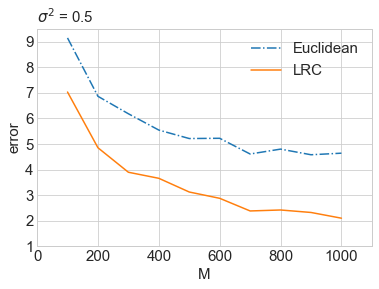

In [21]:
plt.style.use("seaborn-whitegrid")
plt.plot(M_list, error_euclid, linestyle = "-.", label = "Euclidean")
plt.plot(M_list, error_LRC, linestyle = "-", label = "LRC")

plt.legend(loc = "upper right", fontsize = 15)
plt.title("$\sigma^2$ = 0.5", loc = "left", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("M", size = 15)
plt.ylabel("error", size = 15)
plt.xlim((0,1100))
plt.ylim((1, 9.5))
plt.savefig("fig-3.pdf")

In [22]:
p = 100
K = 5
M = 400

V, A = truth(p)
sigma_list = np.arange(0, 0.8, step = 0.1)
sigma_len = len(sigma_list)

error_LRC = np.zeros(sigma_len)
error_euclid = np.zeros(sigma_len)

for i in range(sigma_len):
    sigma = sigma_list[i]
    N_list = data(V, M, sigma = sigma)
    A_LRC = mean_LRC(N_list)
    A_euclid = mean_euclid(N_list)
    error_LRC[i] = np.linalg.norm(A_LRC - A, ord = 'fro')
    error_euclid[i] = np.linalg.norm(A_euclid - A, ord = 'fro')
    

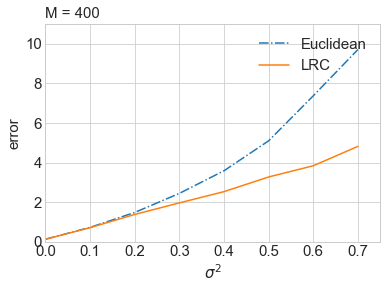

In [23]:
plt.style.use("seaborn-whitegrid")
plt.plot(sigma_list, error_euclid, linestyle = "-.", label = "Euclidean")
plt.plot(sigma_list, error_LRC, linestyle = "-", label = "LRC")

plt.legend(loc = "upper right", fontsize = 15)
plt.title("M = 400", loc = "left", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel("$\sigma^2$", size = 15)
plt.ylabel("error", size = 15)
plt.xlim((0, 0.75))
plt.ylim((0, 11))
plt.savefig("fig-4.pdf")

In [4]:
# experiment two
p = 100
K = 5
M = 50
n = 2000

V = np.mat(np.random.normal(size = (p, K)))
Sigma = V * V.T + 0.3 * np.diag(np.ones(p))
u, a, vt = np.linalg.svd(Sigma)
V_true = np.mat(u[:,:K])
P = V_true * V_true.T

def experiment_two(n, M, repeat = 100):
    
    error_Fan = np.zeros(repeat)
    error_BW = np.zeros(repeat)
    error_LRC = np.zeros(repeat)
    error_cen = np.zeros(repeat)

    for rep in range(repeat):
        V_list = np.zeros((M, p, K))
        Lambda_list = np.zeros((M, K))
        S_cen = np.zeros((p,p))
        for m in range(M):
            X = np.mat(np.random.multivariate_normal(mean = np.zeros(p), cov = Sigma, size = n))
            S_m = X.T * X / n
            u, a, vt = np.linalg.svd(S_m)
            V_m = np.mat(u[:,:K])
            V_list[m,:,:] = V_m
            Lambda_list[m,:] = a[:K]
            
            S_cen = S_cen + S_m / M
        
        u, a, vt = np.linalg.svd(S_cen)
        U_cen = np.mat(u[:,:K])
        error_cen[rep] = np.linalg.norm(U_cen * U_cen.T - P, ord = 'fro')

        N_list = np.zeros((M, p, K))
        for m in range(M):
            N_list[m,:,:] = np.mat(V_list[m,:,:]) * np.diag(Lambda_list[m,:])
        A_LRC = mean_LRC(N_list)
        u, a, vt = np.linalg.svd(A_LRC)
        U_LRC = np.mat(u[:,:K])
        P_LRC = U_LRC * U_LRC.T

        N_list = np.zeros((M, p, K))
        for m in range(M):
            N_list[m,:,:] = np.mat(V_list[m,:,:]) * np.diag(np.sqrt(Lambda_list[m,:]))
        A_BW = mean_euclid(N_list)
        u, a, vt = np.linalg.svd(A_BW)
        U_BW = np.mat(u[:,:K])
        P_BW = U_BW * U_BW.T


        A_Fan = mean_euclid(V_list)
        u, a, vt = np.linalg.svd(A_Fan)
        U_Fan = np.mat(u[:,:K])
        P_Fan = U_Fan * U_Fan.T



        error_BW[rep] = np.linalg.norm(P_BW - P, ord = 'fro')
        error_Fan[rep] = np.linalg.norm(P_Fan - P, ord = 'fro')
        error_LRC[rep] = np.linalg.norm(P_LRC - P, ord = 'fro')
    
    return np.mean(error_Fan), np.mean(error_LRC), np.mean(error_BW), np.mean(error_cen)



In [13]:
n_list = np.arange(500, 3000, step = 500)

n_len = len(n_list)


error_LRC = np.zeros(n_len)
error_Fan = np.zeros(n_len)
error_BW = np.zeros(n_len)
error_cen = np.zeros(n_len)

for i in range(n_len):
    n = n_list[i]
    error_Fan[i], error_LRC[i], error_BW[i], error_cen[i] = experiment_two(n = n, M = 50)



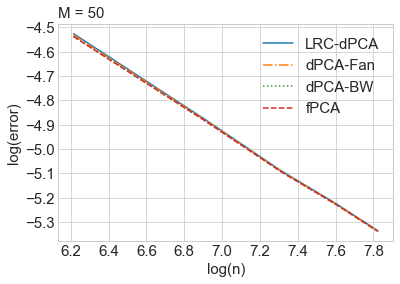

In [14]:
plt.style.use("seaborn-whitegrid")
plt.plot(np.log(n_list), np.log(error_LRC), linestyle = '-', label = "LRC-dPCA")
plt.plot(np.log(n_list), np.log(error_Fan), linestyle = '-.', label = "dPCA-Fan")
plt.plot(np.log(n_list), np.log(error_BW), linestyle = ':', label = "dPCA-BW")
plt.plot(np.log(n_list), np.log(error_cen), linestyle = '--', label = "fPCA")
plt.title("M = 50", loc = "left", fontsize = 15)
plt.legend(loc= "upper right", fontsize = 15)
plt.xlabel("log(n)", size = 15)
plt.ylabel("log(error)", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig("fig-5.pdf")

In [15]:
M_list = np.arange(50, 250, 50)
M_len = len(M_list)

error_LRC = np.zeros(M_len)
error_Fan = np.zeros(M_len)
error_BW = np.zeros(M_len)
error_cen = np.zeros(M_len)

for i in range(M_len):
    M = M_list[i]
    error_Fan[i], error_LRC[i], error_BW[i], error_cen[i] = experiment_two(n = 1000, M = M)

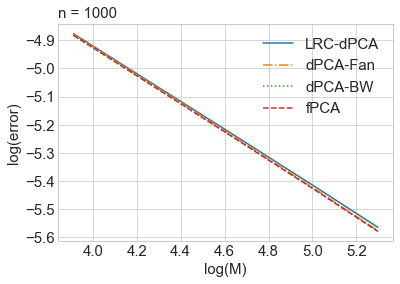

In [16]:
plt.style.use("seaborn-whitegrid")
plt.plot(np.log(M_list), np.log(error_LRC), linestyle = '-', label = "LRC-dPCA")
plt.plot(np.log(M_list), np.log(error_Fan), linestyle = '-.', label = "dPCA-Fan")
plt.plot(np.log(M_list), np.log(error_BW), linestyle = ':', label = "dPCA-BW")
plt.plot(np.log(M_list), np.log(error_cen), linestyle = "--", label = "fPCA")
plt.title("n = 1000", loc = "left", fontsize = 15)
plt.legend(loc= "upper right", fontsize = 15)
plt.xlabel("log(M)", size = 15)
plt.ylabel("log(error)", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig("fig-6.pdf")

In [5]:
# experiment 4

def find_index(V):
    p, K = V.shape
    index = np.zeros(K)
    
    for k in range(K):
        index_candidate = np.zeros(k + 1)
        index_candidate[:k] = index[:k]
        test = np.zeros(p)
        for i in range(p):
            index_candidate[k] = i
            index_candidate = index_candidate.astype(int)
            T = V[index_candidate,:(k + 1)]
            #test[i] = np.linalg.det(T)
            u, a, vt = np.linalg.svd(T)
            test[i] = a[k]
        index[k] = np.argmax(test)
    
    return index.astype(int)

def Log_Cholesky_index(V, index):
    p, K = V.shape
    V = np.mat(V)
    index = index.astype(int)
    R = V[index,:]
    q, r = np.linalg.qr(R.T)
    N = V * q
    for i in range(K):
        ii = index[i]
        if N[ii, i] < 0:
            N[:,i] = - N[:,i]
        N[ii,i] = np.log(N[ii,i])

    return N

def inv_index(N, index):
    p, K = N.shape
    for i in range(K):
        ii = index[i]
        N[ii, i] = np.exp(N[ii, i])
    
    return N
    

def LRC_dPCA(V_list):
    M, p, K = V_list.shape

    V1 = V_list[0,:,:]
    index = find_index(V1)

    N = np.zeros((p,K))
    for m in range(M):
        Vm = V_list[m,:,:]
        N = N + Log_Cholesky_index(Vm, index) / M

    V = inv_index(N, index)
    return np.mat(V)

def experiment_four(n, M, Sigma, P, repeat = 100):
    
    error_Fan = np.zeros(repeat)
    error_BW = np.zeros(repeat)
    error_LRC = np.zeros(repeat)
    error_cen = np.zeros(repeat)
    error_LRC_index = np.zeros(repeat)

    for rep in range(repeat):
        V_list = np.zeros((M, p, K)) # M, p, K
        Lambda_list = np.zeros((M, K))
        S_cen = np.zeros((p,p))
        for m in range(M):
            X = np.mat(np.random.multivariate_normal(mean = np.zeros(p), cov = Sigma, size = n)) # Sigma, n
            S_m = X.T * X / n
            u, a, vt = np.linalg.svd(S_m)
            V_m = np.mat(u[:,:K])
            V_list[m,:,:] = V_m
            Lambda_list[m,:] = a[:K]
            
            S_cen = S_cen + S_m / M
        
        # fPCA
        u, a, vt = np.linalg.svd(S_cen)
        U_cen = np.mat(u[:,:K])
        error_cen[rep] = np.linalg.norm(U_cen * U_cen.T - P, ord = 'fro') # P

        # LRC-dPCA
        N_list = np.zeros((M, p, K))
        for m in range(M):
            N_list[m,:,:] = np.mat(V_list[m,:,:]) * np.diag(Lambda_list[m,:])
        A_LRC = mean_LRC(N_list)
        u, a, vt = np.linalg.svd(A_LRC)
        U_LRC = np.mat(u[:,:K])
        P_LRC = U_LRC * U_LRC.T

        # dPCA-BW
        N_list = np.zeros((M, p, K))
        for m in range(M):
            N_list[m,:,:] = np.mat(V_list[m,:,:]) * np.diag(np.sqrt(Lambda_list[m,:]))
        A_BW = mean_euclid(N_list)
        u, a, vt = np.linalg.svd(A_BW)
        U_BW = np.mat(u[:,:K])
        P_BW = U_BW * U_BW.T
        
        # dPCA-Fan
        A_Fan = mean_euclid(V_list)
        u, a, vt = np.linalg.svd(A_Fan)
        U_Fan = np.mat(u[:,:K])
        P_Fan = U_Fan * U_Fan.T


        error_BW[rep] = np.linalg.norm(P_BW - P, ord = 'fro') 
        error_Fan[rep] = np.linalg.norm(P_Fan - P, ord = 'fro')
        error_LRC[rep] = np.linalg.norm(P_LRC - P, ord = 'fro')

        # LRC-dPCA-index
        N_list = np.zeros((M, p, K))
        for m in range(M):
            N_list[m,:,:] = np.mat(V_list[m,:,:]) * np.diag(Lambda_list[m,:])
        V_LRC = LRC_dPCA(N_list)
        u, a, vt = np.linalg.svd(V_LRC)
        U_LRC = np.mat(u[:,:K])
        P_LRC = U_LRC * U_LRC.T

        error_LRC_index[rep] = np.linalg.norm(P_LRC - P, ord = 'fro')

    
    return np.mean(error_Fan), np.mean(error_LRC), np.mean(error_BW), np.mean(error_cen), np.mean(error_LRC_index)

In [6]:
# simulation
p = 100
K = 5

V = np.mat(np.random.normal(size = (p, K)))
Sigma = V * V.T + np.diag(np.ones(p))
u, a, vt = np.linalg.svd(Sigma)
V_true = np.mat(u[:,:K])
P = V_true * V_true.T

M_list = np.arange(50, 250, 50)
T = len(M_list)
error_LRC = np.zeros(T)
error_LRC_index = np.zeros(T)
error_cen = np.zeros(T)
error_Fan = np.zeros(T)
error_BW = np.zeros(T)

for i in range(T):
    M = M_list[i]
    error_Fan[i], error_LRC[i], error_BW[i], error_cen[i], error_LRC_index[i] = experiment_four(n = 1000, M = M, Sigma = Sigma, P = P)

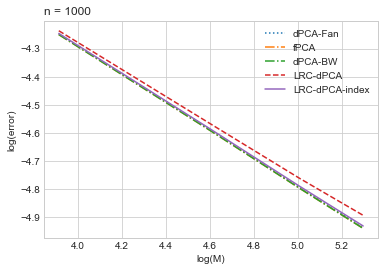

In [7]:
# plot
plt.style.use("seaborn-whitegrid")
plt.plot(np.log(M_list), np.log(error_Fan), linestyle = ":", label = "dPCA-Fan")
plt.plot(np.log(M_list), np.log(error_cen), linestyle = "-.", label = "fPCA")
plt.plot(np.log(M_list), np.log(error_BW), linestyle = "-.", label = "dPCA-BW")
plt.plot(np.log(M_list), np.log(error_LRC), linestyle = "--", label = "LRC-dPCA")
plt.plot(np.log(M_list), np.log(error_LRC_index), linestyle = "-", label = "LRC-dPCA-index")
plt.legend(loc = "upper right")
plt.xlabel("log(M)")
plt.ylabel("log(error)")
plt.title("n = 1000", loc = "left")
plt.savefig("figgg.pdf")